# Deep Learning
## ResNet50

Member 1: Anish Batra, ab8166

Member 2: Prashant Mahajan, prm349

### Importing libraries

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from importlib import reload
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import glob
from shutil import copyfile
from keras.models import load_model
from keras import optimizers

Using TensorFlow backend.


### Loading pretrained ResNet50 model from keras

In [2]:
img_shape = (224, 224, 3)

resnet_model = ResNet50(include_top=False, input_shape=img_shape)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Loading Images and Augmentation

In [3]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]


def append_ext(fn):
    return fn + ".jpg"


traindf = pd.read_csv('training_solutions_rev1.csv')

traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext)

datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="data/input/images_training_rev1/images_training_rev1",
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="data/input/images_training_rev1/images_training_rev1",
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 59367 images.
Found 1211 images.


### Adjust outputs layers of loaded model according to the given training data

In [4]:
# Flatten output of last layer before adding output layer (Dense layer)
x = Flatten()(resnet_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Load the modified model
model = Model(inputs=resnet_model.input, outputs=x)

### Visualize architecture of modified model; ready to be compiled

In [5]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Fine tune all layers of the model | Adam Optimizer (decay)

In [6]:
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(lr=0.001, decay=5e-4)

model.compile(optimizer, loss='mse', metrics=["accuracy"])

### Load callbacks - ModelCheckpoint, Callback, EarlyStopping

In [7]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='today_20_epochs/weights.hdf5', verbose=2, save_best_only=True)

### Fit the model

In [8]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=[history, checkpointer, early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
927/927 [==============================] - 735s 793ms/step - loss: 0.0170 - acc: 0.6881 - val_loss: 0.0317 - val_acc: 0.5061

Epoch 00001: val_loss improved from inf to 0.03167, saving model to today_20_epochs/weights.hdf5
Epoch 2/30
927/927 [==============================] - 716s 773ms/step - loss: 0.0130 - acc: 0.7360 - val_loss: 0.0166 - val_acc: 0.7280

Epoch 00002: val_loss improved from 0.03167 to 0.01661, saving model to today_20_epochs/weights.hdf5
Epoch 3/30
927/927 [==============================] - 727s 784ms/step - loss: 0.0128 - acc: 0.7348 - val_loss: 0.0146 - val_acc: 0.7210

Epoch 00003: val_loss improved from 0.01661 to 0.01464, saving model to today_20_epochs/weights.hdf5
Epoch 4/30
927/927 [==============================] - 723s 779ms/step - loss: 0.0101 - acc: 0.7758 - val_loss: 0.0101 - val_acc: 0.7777

Epoch 00004: val_loss improved from 0.01464 to 0.01012, saving model to today_20_epochs/weights.hdf5
Epoc

### Plot training and validation loss

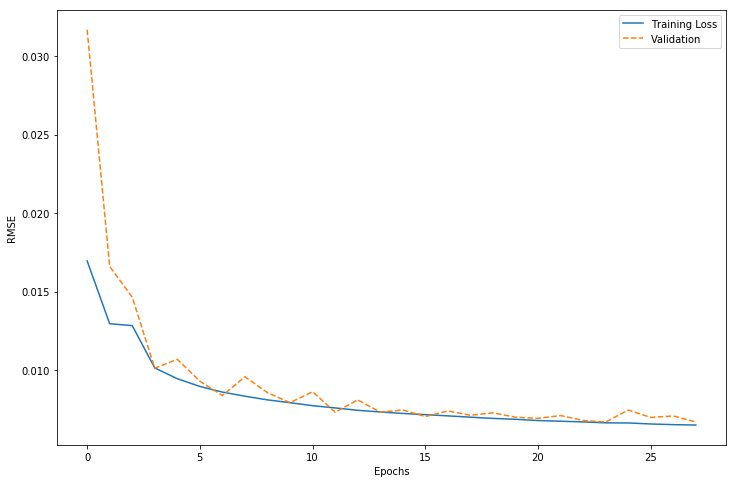

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Load the best model from saved weights file

In [21]:
from keras.models import load_model

model = load_model('today_20_epochs/weights.hdf5')

### Prepare ImageDataGenerator for test data

In [1]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "Kaggle-Test/",
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(224, 224),
    seed=123,
    shuffle=False)

### Generate predictions for test data

In [ ]:
test_generator.reset()

predictions = model.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)

### Save results to .csv file

In [14]:
def get_id(fname):
    return fname.replace(".jpg", "").split("/")[1]


header = open('all_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")